In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests
from scipy.integrate import simps

# Read data

In [2]:
# read meta data
df_meta = pd.read_csv('../../our_data/meta_data.csv', index_col=0)

# read bacterial relative abundance
df_16S_absab = pd.read_csv('../../our_data/16S_absolute_abundance_species.csv', index_col=0)

# read qPCR
df_qpcr = pd.read_csv('../../our_data/qPCR.csv', index_col=0).rename({'Value':'qPCR'},axis=1)
                      
# read scfa
df_scfa = pd.read_csv('../../our_data/SCFA.csv', index_col=0)

# join tables
df = pd.merge(df_meta, df_16S_absab, left_index=True, right_index=True)
df = pd.merge(df, df_qpcr, left_index=True, right_index=True)
df = pd.merge(df, df_scfa, left_index=True, right_index=True)

# select for inulin
df = df[df.Diet=='Inulin']

# add eco-groups
primary_degraders = ['Bacteroides-acidifaciens','Muribaculaceae','Faecalibaculum','Parasutterella','Bacteroides']
df_inulin_responders = pd.read_csv('../figure4_individualized_response/inulin/individualized_response_test_for_species_absolute_abundance.csv', index_col=0)
df_inulin_responders = df_inulin_responders[(df_inulin_responders.P_rsp_corrected<0.05)&(df_inulin_responders.meanAbsab_ratio>1)]
generic_responders = list(set(df_inulin_responders.Variable) - set(primary_degraders))
non_responders = list(set(df_16S_absab.columns) - set(primary_degraders) - set(generic_responders))

df['PrimaryDegraders'] = df[primary_degraders].sum(axis=1)
df['GenericResponders'] = df[generic_responders].sum(axis=1)
df['NonResponders'] = df[non_responders].sum(axis=1)

df.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,A2,ASF356,Acetatifactor,Acetatifactor-muris,Acidovorax,...,Acetate,Propionate,Butyrate,Iso-butyrate,Iso-valerate,Valerate,Total,PrimaryDegraders,GenericResponders,NonResponders
SampleID,,,,,,,,,,,,,,,,,,,,,
sample141,BI1,Beijing,0,Inulin,A,0.00000,58318.68678,98146.08263,0.0,0.0,...,5.233899,1.930933,1.109582,0.209460,0.103316,0.115502,8.702693,4.824662e+07,5.656913e+06,1.941728e+07
sample142,BI2,Beijing,0,Inulin,B,79938.73811,25274.74808,33503.73582,0.0,0.0,...,13.459823,3.621771,1.546647,0.331414,0.176167,0.100110,19.235932,2.459233e+07,3.904067e+06,1.712217e+07
sample143,BI3,Beijing,0,Inulin,D,0.00000,137987.68630,64115.49061,0.0,0.0,...,18.075378,2.859916,1.682656,0.234600,0.144922,0.220280,23.217751,5.642860e+07,4.615758e+07,5.995774e+07
sample144,BI4,Beijing,0,Inulin,E,61973.98659,142310.63590,94108.64630,0.0,0.0,...,12.580368,3.148773,1.477688,0.156928,0.105900,0.144724,17.614381,2.961668e+07,9.034430e+06,9.511630e+07
sample145,BI5,Beijing,0,Inulin,C,0.00000,122899.45460,119532.34630,0.0,0.0,...,8.065127,3.134209,1.835172,0.308168,0.174705,0.060569,13.577951,6.287233e+07,2.936118e+07,6.838260e+07


# Correlation between qPCR and SCFA

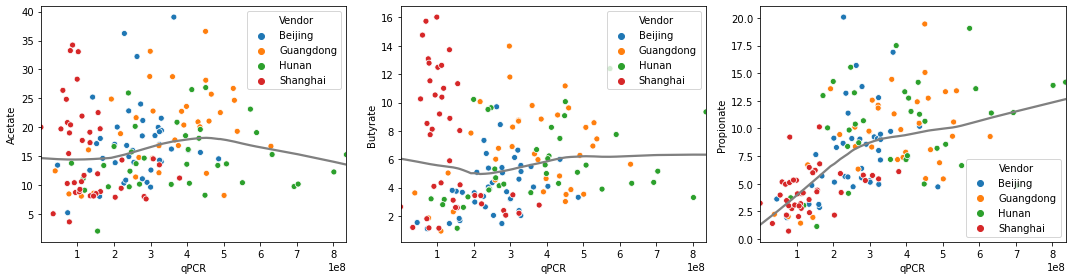

In [34]:
fig, ax=plt.subplots(nrows=1, ncols=3, figsize=(15,4))

lines = []
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    _ = sns.regplot(x='qPCR', y=scfa, data=df, ax=ax[k], scatter=False, color='gray', ci=68, lowess=True)
    _ = sns.scatterplot(x='qPCR', y=scfa, data=df, ax=ax[k], hue='Vendor')
    coef, P = spearmanr(df['qPCR'], df[scfa])
    lines.append([scfa, coef, P])

df_res = pd.DataFrame(lines, columns=['SCFA','Coef','P'])
df_res['P_adj'] = multipletests(df_res.P, method='fdr_bh')[1]

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("correlation_qPCR_scfa.svg", format="svg")

In [5]:
df_res

,SCFA,Coef,P,P_adj
0,Acetate,0.174981,3.107103e-02,4.660654e-02
1,Butyrate,0.106873,1.900287e-01,1.900287e-01
2,Propionate,0.638543,8.759854e-19,2.627956e-18


# Correlation between eco-groups and propionate

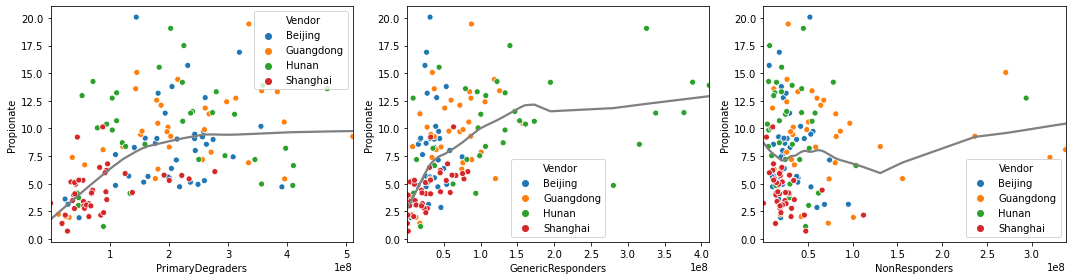

In [35]:
fig, ax=plt.subplots(nrows=1, ncols=3, figsize=(15,4))

lines = []
for k,ecogroup in enumerate(['PrimaryDegraders','GenericResponders','NonResponders']):
    _ = sns.regplot(x=ecogroup, y='Propionate', data=df, ax=ax[k], scatter=False, color='gray', ci=68, lowess=True)
    _ = sns.scatterplot(x=ecogroup, y='Propionate', data=df, ax=ax[k], hue='Vendor')
    coef, P = spearmanr(df[ecogroup], df['Propionate'])
    lines.append([ecogroup, coef, P])

df_res = pd.DataFrame(lines, columns=['Ecogroup','Coef','P'])
df_res['P_adj'] = multipletests(df_res.P, method='fdr_bh')[1]

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("correlation_ecogroup_propionate.svg", format="svg")

In [44]:
df_res

,Ecogroup,Coef,P,P_adj
0,PrimaryDegraders,0.577321,6.934759e-15,1.040214e-14
1,GenericResponders,0.611927,5.511262e-17,1.653379e-16
2,NonResponders,0.026056,7.499971e-01,7.499971e-01


# Correlation between individual bacterial taxa in the ecogroup of degrader or generic responder with propionate

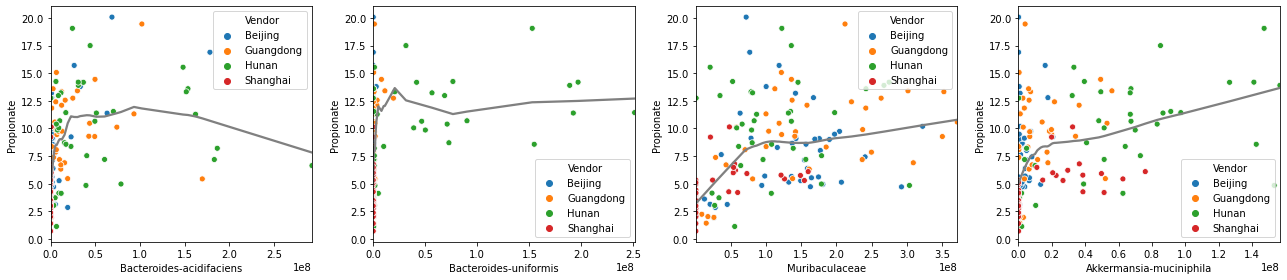

In [36]:
lines = []
for k,taxa in enumerate(primary_degraders + generic_responders):
    coef, P = spearmanr(df[taxa], df['Propionate'])
    lines.append([taxa, coef, P])
df_res = pd.DataFrame(lines, columns=['Taxa','Coef','P'])
df_res['P_adj'] = multipletests(df_res.P, method='fdr_bh')[1]
df_res = df_res.sort_values('Coef', ascending=False)

fig, ax=plt.subplots(nrows=1, ncols=4, figsize=(18,4))
for k,taxa in enumerate(list(df_res.iloc[0:4]['Taxa'])):
    _ = sns.regplot(x=taxa, y='Propionate', data=df, ax=ax[k], scatter=False, color='gray', ci=68,lowess=True)
    _ = sns.scatterplot(x=taxa, y='Propionate', data=df, ax=ax[k], hue='Vendor')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("correlation_ecogroup_propionate.svg", format="svg")

In [47]:
df_res[df_res.P_adj<0.05]

,Taxa,Coef,P,P_adj
0,Bacteroides-acidifaciens,0.628082,4.678451e-18,1.731027e-16
6,Bacteroides-uniformis,0.589792,1.297403e-15,2.400196e-14
1,Muribaculaceae,0.534223,1.360017e-12,1.677355e-11
30,Akkermansia-muciniphila,0.518964,7.412876e-12,6.856910e-11
21,Alloprevotella,0.459474,2.610942e-09,1.610081e-08
32,Bacteroides-caecimuris,0.395526,4.575357e-07,2.418403e-06
33,Muribaculum,0.356466,6.559527e-06,3.033781e-05
13,Helicobacter-mastomyrinus,0.331382,3.042331e-05,1.250736e-04
24,mouse-gut-metagenome,0.285393,3.653502e-04,1.228905e-03
17,Prevotellaceae-UCG-001,0.283122,4.087843e-04,1.260418e-03


# Correlation between baseline level of top four taxa and propionate

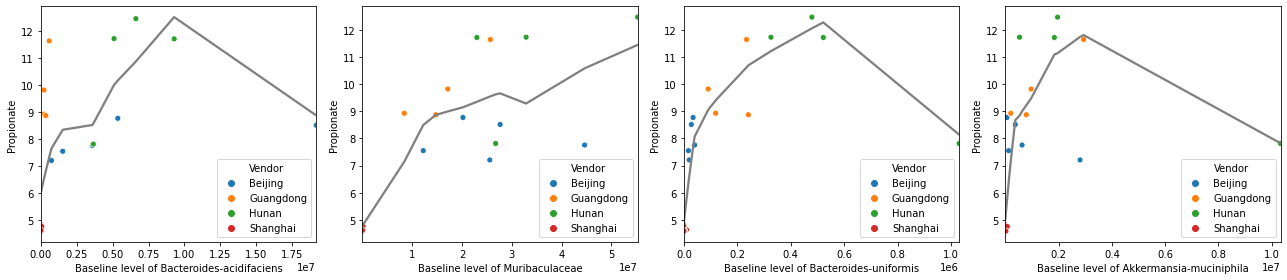

In [37]:
lines = []
for taxa in ['Bacteroides-acidifaciens','Muribaculaceae', 'Bacteroides-uniformis','Akkermansia-muciniphila']:
    baseline = []
    for mice in set(df.MiceID):
        df_tmp = df[df.MiceID==mice].sort_values(by='Day')
        vendor = list(set(df_tmp.Vendor))[0]
        x = list(df_tmp.Day)
        baseline = df_tmp.loc[df_tmp.Day==0,taxa].values[0]
        y = list(df_tmp['Propionate'])
        mean_ppa = simps(y,x)/np.max(x)
        lines.append([taxa, mice, vendor, baseline, mean_ppa])
df_bsl_ppa = pd.DataFrame(lines, columns = ['Taxa','MiceID','Vendor','Baseline','Propionate'])
df_bsl_ppa = df_bsl_ppa.sort_values('Vendor')

lines = []
fig, ax=plt.subplots(nrows=1, ncols=4, figsize=(18,4))
for k,taxa in enumerate(['Bacteroides-acidifaciens','Muribaculaceae', 'Bacteroides-uniformis','Akkermansia-muciniphila']):
    _ = sns.regplot(x='Baseline', y='Propionate', data=df_bsl_ppa[df_bsl_ppa.Taxa==taxa], ax=ax[k], scatter=False, color='gray', ci=68, lowess=True)
    _ = sns.scatterplot(x='Baseline', y='Propionate', data=df_bsl_ppa[df_bsl_ppa.Taxa==taxa], ax=ax[k], hue='Vendor')
    coef, P = spearmanr(df_bsl_ppa[df_bsl_ppa.Taxa==taxa].Baseline, df_bsl_ppa[df_bsl_ppa.Taxa==taxa].Propionate)
    lines.append([taxa, coef, P])
    _ = ax[k].set_xlabel('Baseline level of %s'%(taxa))

df_res = pd.DataFrame(lines, columns=['SCFA','Coef','P'])
df_res['P_adj'] = multipletests(df_res.P, method='fdr_bh')[1]

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("correlation_baseline_top4_propionate.svg", format="svg")

In [61]:
df_res

,SCFA,Coef,P,P_adj
0,Bacteroides-acidifaciens,0.657379,0.003030,0.004040
1,Muribaculaceae,0.680083,0.001900,0.003799
2,Bacteroides-uniformis,0.851088,0.000008,0.000030
3,Akkermansia-muciniphila,0.640867,0.004160,0.004160


# Correlation of baseline microbiota with total bacterial laod

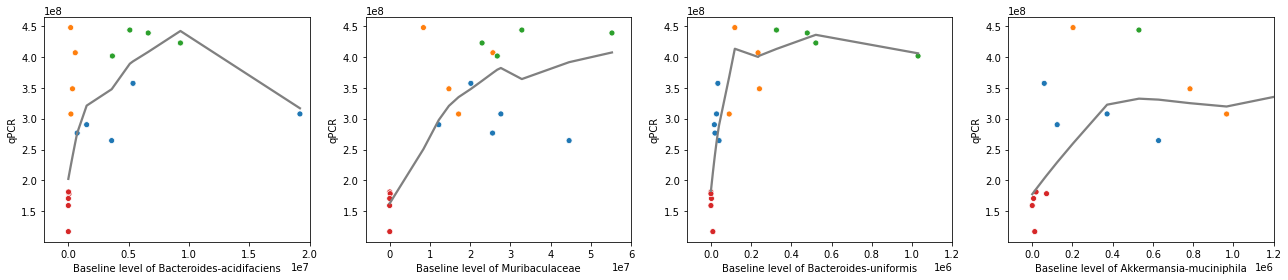

In [33]:
lines = []
for taxa in primary_degraders+['Bacteroides-uniformis','Akkermansia-muciniphila']:
    baseline = []
    for mice in set(df.MiceID):
        df_tmp = df[df.MiceID==mice].sort_values(by='Day')
        vendor = list(set(df_tmp.Vendor))[0]
        x = list(df_tmp.Day)
        baseline = df_tmp.loc[df_tmp.Day==0,taxa].values[0]
        y = list(df_tmp['qPCR'])
        mean_qpcr = simps(y,x)/np.max(x)
        lines.append([taxa, mice, vendor, baseline, mean_qpcr])
df_bsl_qpcr = pd.DataFrame(lines, columns = ['Taxa','MiceID','Vendor','Baseline','qPCR'])
df_bsl_qpcr = df_bsl_qpcr.sort_values('Vendor')

lines = []
for k,taxa in enumerate(primary_degraders+['Bacteroides-uniformis','Akkermansia-muciniphila']):
    coef, P = spearmanr(df_bsl_qpcr[df_bsl_qpcr.Taxa==taxa].Baseline, df_bsl_qpcr[df_bsl_qpcr.Taxa==taxa].qPCR)
    lines.append([taxa, coef, P])
    
df_res = pd.DataFrame(lines, columns=['SCFA','Coef','P'])
df_res['P_adj'] = multipletests(df_res.P, method='fdr_bh')[1]

fig, ax=plt.subplots(nrows=1, ncols=4, figsize=(18,4))
for k,taxa in enumerate(['Bacteroides-acidifaciens','Muribaculaceae', 'Bacteroides-uniformis','Akkermansia-muciniphila']):
    _ = sns.regplot(x='Baseline', y='qPCR', data=df_bsl_qpcr[df_bsl_qpcr.Taxa==taxa], ax=ax[k], scatter=False, color='gray', ci=68, lowess=True)
    _ = sns.scatterplot(x='Baseline', y='qPCR', data=df_bsl_qpcr[df_bsl_qpcr.Taxa==taxa], ax=ax[k], hue='Vendor')
    _ = ax[k].set_xlabel('Baseline level of %s'%(taxa))
    if k==0:
        _ = ax[k].set_xlim([-2e6, 2e7])
    elif k==1:
        _ = ax[k].set_xlim([-6e6, 6e7])
    elif k==2:
        _ = ax[k].set_xlim([-1.2e5, 1.2e6])
    elif k==3:
        _ = ax[k].set_xlim([-1.2e5, 1.2e6])
    _ = ax[k].legend().remove()

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("correlation_baseline_total_bacteria_load.svg", format="svg")

In [27]:
df_res

,SCFA,Coef,P,P_adj
0,Bacteroides-acidifaciens,0.665635,0.002568,0.008989
1,Muribaculaceae,0.620227,0.006032,0.010941
2,Faecalibaculum,0.065015,0.797715,0.797715
3,Parasutterella,0.153767,0.542403,0.632804
4,Bacteroides,-0.310630,0.209625,0.293475
5,Bacteroides-uniformis,0.849019,0.000008,0.000059
6,Akkermansia-muciniphila,0.618163,0.006252,0.010941
